In [3]:
import os
import torch
import torchvision
from torch import nn
import matplotlib.pyplot as plt
from torchvision import datasets, transforms
import torchinfo
import modules

In [4]:
num_workers = os.cpu_count()
print(num_workers)
device = "cuda" if torch.cuda.is_available() else "cpu"
print(device)

24
cuda


In [5]:
train_dir = "modules/data/train_organized/"
test_dir = "modules/data/test_organized/"


In [6]:
weights = torchvision.models.EfficientNet_V2_L_Weights.DEFAULT
weights

EfficientNet_V2_L_Weights.IMAGENET1K_V1

In [7]:
auto_transforms = weights.transforms()
auto_transforms

ImageClassification(
    crop_size=[480]
    resize_size=[480]
    mean=[0.5, 0.5, 0.5]
    std=[0.5, 0.5, 0.5]
    interpolation=InterpolationMode.BICUBIC
)

In [8]:
from modules import data_setup
train_dataloader, test_dataloader, class_names = data_setup.create_dataloaders(train_dir=train_dir, test_dir=test_dir, transform=auto_transforms, batch_size=32, num_workers=num_workers)

In [9]:
model = torchvision.models.efficientnet_v2_l(weights=weights).to(device)
model

EfficientNet(
  (features): Sequential(
    (0): Conv2dNormActivation(
      (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
      (1): BatchNorm2d(32, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
      (2): SiLU(inplace=True)
    )
    (1): Sequential(
      (0): FusedMBConv(
        (block): Sequential(
          (0): Conv2dNormActivation(
            (0): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
            (1): BatchNorm2d(32, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
            (2): SiLU(inplace=True)
          )
        )
        (stochastic_depth): StochasticDepth(p=0.0, mode=row)
      )
      (1): FusedMBConv(
        (block): Sequential(
          (0): Conv2dNormActivation(
            (0): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
            (1): BatchNorm2d(32, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
  

In [10]:
from torchinfo import summary
summary(
    model=model,
    input_size=(32,3,480,480),
    col_names=["input_size","output_size","num_params","trainable"],
    col_width=20,
    row_settings=["var_names"]
)

Layer (type (var_name))                                      Input Shape          Output Shape         Param #              Trainable
EfficientNet (EfficientNet)                                  [32, 3, 480, 480]    [32, 1000]           --                   True
├─Sequential (features)                                      [32, 3, 480, 480]    [32, 1280, 15, 15]   --                   True
│    └─Conv2dNormActivation (0)                              [32, 3, 480, 480]    [32, 32, 240, 240]   --                   True
│    │    └─Conv2d (0)                                       [32, 3, 480, 480]    [32, 32, 240, 240]   864                  True
│    │    └─BatchNorm2d (1)                                  [32, 32, 240, 240]   [32, 32, 240, 240]   64                   True
│    │    └─SiLU (2)                                         [32, 32, 240, 240]   [32, 32, 240, 240]   --                   --
│    └─Sequential (1)                                        [32, 32, 240, 240]   [32, 32, 240

In [11]:
for param in model.features.parameters():
    param.requires_grad = False

In [12]:
torch.manual_seed(42)
torch.cuda.manual_seed(42)

output_shape = len(class_names)

model.classifier = torch.nn.Sequential(
    torch.nn.Dropout(p=0.2, inplace=True),
    torch.nn.Linear(in_features=1280, out_features=output_shape, bias=True)
).to(device)

In [13]:
from torchinfo import summary
summary(
    model=model,
    input_size=(32,3,480,480),
    col_names=["input_size","output_size","num_params","trainable"],
    col_width=20,
    row_settings=["var_names"]
)

Layer (type (var_name))                                      Input Shape          Output Shape         Param #              Trainable
EfficientNet (EfficientNet)                                  [32, 3, 480, 480]    [32, 6]              --                   Partial
├─Sequential (features)                                      [32, 3, 480, 480]    [32, 1280, 15, 15]   --                   False
│    └─Conv2dNormActivation (0)                              [32, 3, 480, 480]    [32, 32, 240, 240]   --                   False
│    │    └─Conv2d (0)                                       [32, 3, 480, 480]    [32, 32, 240, 240]   (864)                False
│    │    └─BatchNorm2d (1)                                  [32, 32, 240, 240]   [32, 32, 240, 240]   (64)                 False
│    │    └─SiLU (2)                                         [32, 32, 240, 240]   [32, 32, 240, 240]   --                   --
│    └─Sequential (1)                                        [32, 32, 240, 240]   [32, 

In [14]:
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)

In [15]:
from modules import engine

results = engine.train(
    model=model,
    train_dataloader=train_dataloader,
    test_dataloader=test_dataloader,
    optimizer=optimizer,
    loss_fn=loss_fn,
    epochs=5,
    device=device
)


  0%|          | 0/5 [00:00<?, ?it/s]

Epoch: 1 | train_loss: 1.4829 | train_acc: 0.6263 | test_loss: 1.3711 | test_acc: 0.8638
Epoch: 2 | train_loss: 0.2686 | train_acc: 0.9013 | test_loss: 0.2074 | test_acc: 0.9766
Epoch: 3 | train_loss: 0.1404 | train_acc: 0.9629 | test_loss: 0.2046 | test_acc: 0.9844
Epoch: 4 | train_loss: 0.0699 | train_acc: 0.9763 | test_loss: 0.2010 | test_acc: 0.9821
Epoch: 5 | train_loss: 0.0372 | train_acc: 0.9821 | test_loss: 0.1777 | test_acc: 0.9922


In [16]:
def plot_loss_curves(results):
    loss = results["train_loss"]
    test_loss = results["test_loss"]

    accuracy = results["train_acc"]
    test_accuracy = results["test_acc"]

    epochs = range(len(results["train_loss"]))

    plt.figure(figsize=(15, 7))

    plt.subplot(1, 2, 1)
    plt.plot(epochs, loss, label="train_loss")
    plt.plot(epochs, test_loss, label="test_loss")
    plt.title("Loss")
    plt.xlabel("Epochs")
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(epochs, accuracy, label="train_accuracy")
    plt.plot(epochs, test_accuracy, label="test_accuracy")
    plt.title("Accuracy")
    plt.xlabel("Epochs")
    plt.legend()

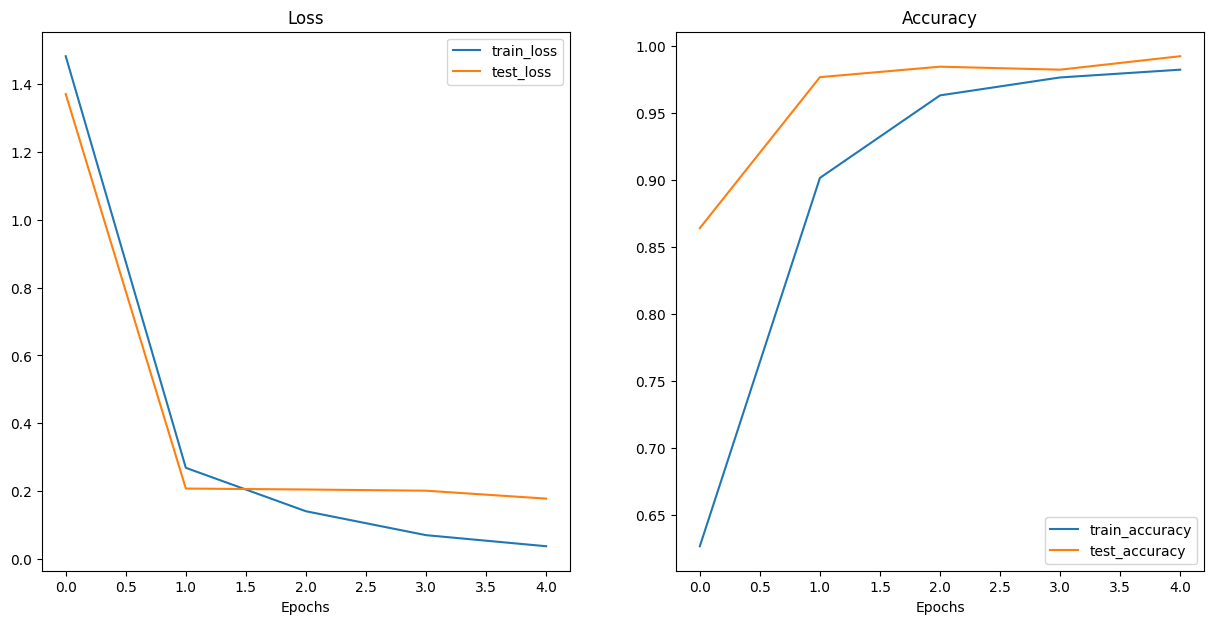

In [17]:
plot_loss_curves(results)

In [18]:
from typing import List, Tuple
from PIL import Image
def pred_and_plot_image(model: torch.nn.Module,
                        image_path: str, 
                        class_names: List[str],
                        image_size: Tuple[int, int] = (224, 224),
                        transform: torchvision.transforms = None,
                        device: torch.device=device):
    
    img = Image.open(image_path)

    if transform is not None:
        image_transform = transform
    else:
        image_transform = transforms.Compose([
            transforms.Resize(image_size),
            transforms.ToTensor(),
            transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                 std=[0.229, 0.224, 0.225]),
        ])

    model.to(device)

    model.eval()
    with torch.inference_mode():
      transformed_image = image_transform(img).unsqueeze(dim=0)

      target_image_pred = model(transformed_image.to(device))

    target_image_pred_probs = torch.softmax(target_image_pred, dim=1)

    target_image_pred_label = torch.argmax(target_image_pred_probs, dim=1)

    plt.figure()
    plt.imshow(img)
    plt.title(f"Pred: {class_names[target_image_pred_label]} | Prob: {target_image_pred_probs.max():.3f}")
    plt.axis(False);

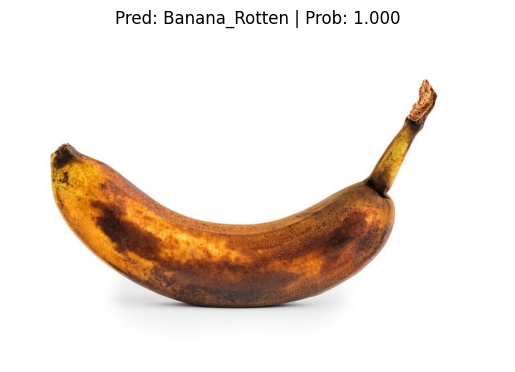

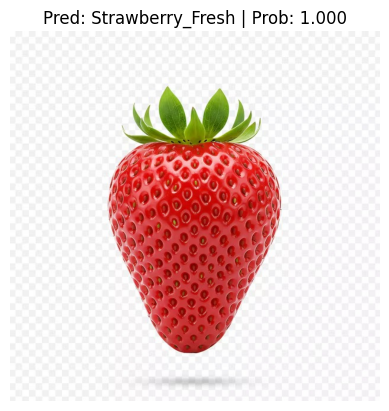

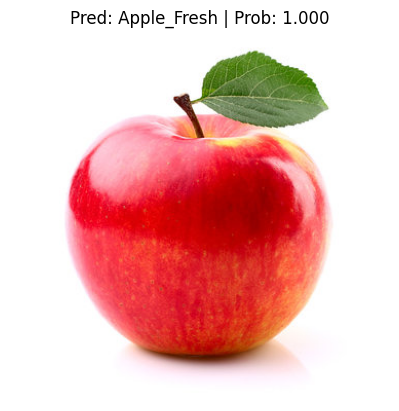

In [19]:
import random
from pathlib import Path
num_images_to_plot = 3
test_image_path_list = list(Path(test_dir).glob("*/*.jpg")) 
test_image_path_sample = random.sample(population=test_image_path_list, 
                                       k=num_images_to_plot) 

for image_path in test_image_path_sample:
    pred_and_plot_image(model=model, 
                        image_path=image_path,
                        class_names=class_names,
                        transform=weights.transforms(), 
                        image_size=(480, 480))

In [22]:
custom_image_path = "/Users/raghavmehta/Downloads/Fruit-Freshness-Classification/banana.jpg"

pred_and_plot_image(model=model, image_path=custom_image_path, class_names=class_names)

FileNotFoundError: [Errno 2] No such file or directory: '/Users/raghavmehta/Downloads/Fruit-Freshness-Classification/banana.jpg'